# Spatiotemporal PM10 concentration prediction by Plume Labs

https://challengedata.ens.fr/challenges/7

## Problem definition 

In order to provide air quality forecasts, Plume Labs has built a unique database with readings collected by monitoring stations all over the world. The problem consists in predicting the PM10 concentration measured at some stations using urban features evaluated at the station location as well as the readings provided by the stations nearby. 

The dataset gives the measures provided by 85 stations across Europe.

For each PM10 reading, the dataset provides the following information: 
- Land-use characterization of the station location (i.e. is it located in a residential area, industrial area, …) 
- Roads density evaluated at the station location 
- PM10 readings at the closest stations as well as the distance to these stations 

The accuracy obtained by such a prediction model is a very good indicator of how an air quality prediction model performs in locations where there is no monitoring station.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_input = pd.read_csv(r'C:\Users\alexi\training_input_lat8cht.csv',dtype=np.float64)
data_output = pd.read_csv(r'C:\Users\alexi\training_output_Z18GQCh.csv',dtype=np.float64)

In [14]:
data_input.head()

,ID,station_id,hdres_100,hdres_500,ldres_100,ldres_500,industry_100,industry_500,urbgreen_100,urbgreen_500,...,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9
0,0.0,105.0,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,53.0,46.0,52.0,44.0,40.0,38.0,54.0,36.0,39.0,42.0
1,1.0,105.0,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,55.0,47.0,54.0,45.0,41.0,39.0,55.0,37.0,40.0,43.0
2,2.0,105.0,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,84.5,54.0,78.0,49.0,47.0,42.0,63.0,42.0,48.0,49.0
3,3.0,105.0,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,97.0,59.0,84.0,55.0,58.0,48.0,72.0,51.0,57.0,59.0
4,4.0,105.0,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,99.0,67.0,95.0,63.0,67.0,48.0,82.0,59.0,64.0,65.0


36 features

695255 training samples

## Data visualization


<b> 1) Plot output data</b> <br>
To get an idea of what we should expect.
I use numpy and rolling mean to plot the evolution of PM10 concentration at each station. 


<b> 2) Plot histigrams of input data </b><br>
Have a look at distributions in order to find : 
non sense outliers, features that should be binary, or non sense boundaries.
    
    
<b> 3) Plot an heatmap </b><br>
Looking at correlation should help us to identify redundant features.


In [15]:
# Fonction : create rolling mean from data according to a window size

def movingaverage(interval, window_size): 
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [16]:
# Reshape the data_output (values,stations x 1) as (stations x values)

output_0 = pd.concat([data_input.station_id,data_output.value], axis=1)
output_0 = output_0.sort_values('station_id')
output = output_0.as_matrix().astype(int)

tab = np.empty([115,8779])
y=0
for i in range(output.shape[0]-1):
    tab[output[i,0],y] = output[i,1]
    if output[i,0] == output[i+1,0]:
        y=y+1
    else:
        y=0
        
tab = tab[~np.all(tab == 0, axis=1)] #remove null rows

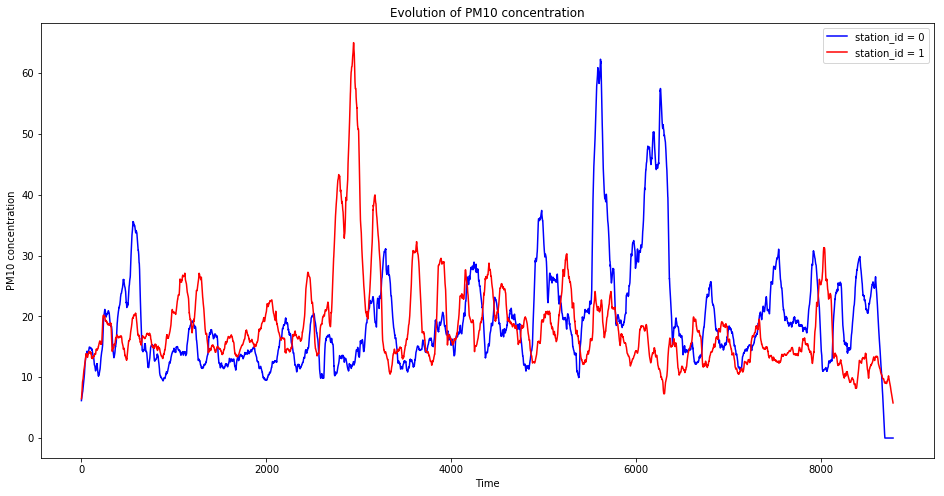

In [17]:
# Use matplotlib to plot results for some stations

x = np.arange(0,8779)
window = 100
y1 = movingaverage(tab[0,:].T,window) 
y2 = movingaverage(tab[1,:].T,window) 
y3 = movingaverage(tab[2,:].T,window) 
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Evolution of PM10 concentration")
plt.plot(x, y1, color ='b', label="station_id = 0")
plt.plot(x, y2, color ='r', label="station_id = 1")
#plt.plot(x, y3, color ='g', label="station_id = 2")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("PM10 concentration")
plt.show()

For each station, we can observe many amplitudes of oscillations, but the period of oscillations looks quite regular.<br>
Later it could be interesting to consider it as time series.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027500215E80>,
      dtype=object)

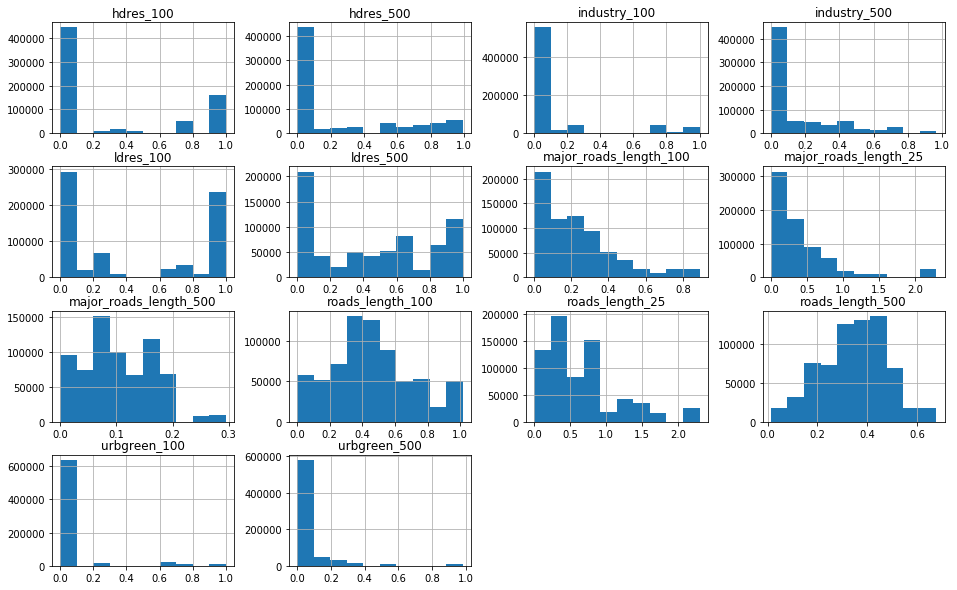

In [18]:
# Use pandas library to plot each feature distribution
train_short = data_input.loc[:, 'hdres_100' : 'major_roads_length_500']
train_short.hist(figsize=(16,10))

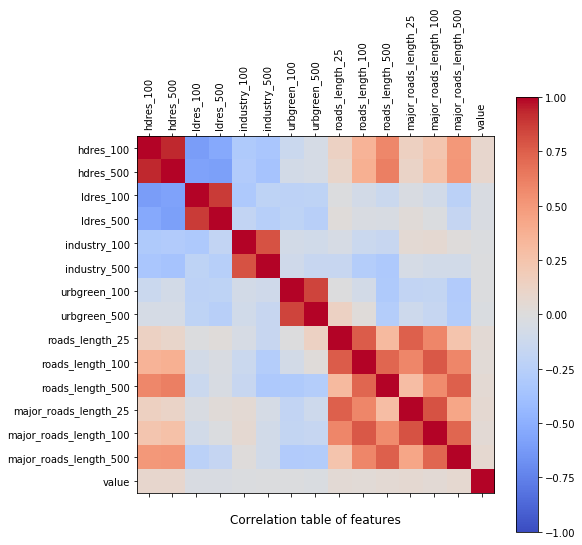

In [19]:
#Use matplotlib to plot correlations between features

train_short.loc[:,'value']=data_output.value
corr = train_short.corr()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_short.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_short.columns)
ax.set_yticklabels(train_short.columns)
plt.title("Correlation table of features", y=-0.1)
plt.show()

First, we observe that high density residential areas and roads have a positive correlation with PM10 concentration.<br>
While the presence of low density residential areas and parks have a negative correlation with PM10 concentration.<br>

We can see that <b>hdres</b>, <b>idres</b>, <b>industry</b> and <b>urbgreen</b> variables are highly correlated.<br>
Later, if we want to reduce our number of features, combining those features two by two.<br>

## Data cleaning

For distances and values : Some values may be <b>𝑛𝑎𝑛</b>, which means that the corresponding monitoring station did not return any value at this moment.<br>
Then I'm setting those $values = 1$ at far $distances = 1000000$ 

In [ ]:
def check_dataset(data):
    print('There are Nan values in dataset :', np.any(np.isnan(data)))
    print('There are only finite values in dataset :', np.all(np.isfinite(data)))

In [ ]:
check_dataset(data_input)

In [ ]:
%%capture
data_input.loc[:, 'value_0' : 'value_9'].fillna(value=1,inplace=True)
data_input.loc[:, 'distance_0' : 'distance_9'].fillna(value=1000000,inplace=True)

## Data preprocessing

Here I choose to combine $value$ and $distance$ features for the 10 closest stations.<br>

For each close station of each sample I calculate the intensity recieved by those stations : 
$intensity = \frac{value}{distance^2}$ <br>

Then I create a new feature : $neighborhood = \frac{1}{number ~of~ stations} \sum_{i=0}^{9} intensity(_i) $


In [4]:
def preprocess(data):
    
    data.loc[:, 'value_0' : 'value_9'].fillna(value=1,inplace=True)
    data.loc[:, 'distance_0' : 'distance_9'].fillna(value=1000000,inplace=True)
    
    data.loc[:,'int'] = 0
    
    X = data.loc[:, 'hdres_100' : 'major_roads_length_500']
    X.loc[:,'sum'] = 0
    
    for i in range(9):
        data.loc[:,'intensity_{}'.format(i)] = (data.loc[:,'value_{}'.format(i)]
                                                   /data.loc[:,'distance_{}'.format(i)]
                                                   /data.loc[:,'distance_{}'.format(i)])
     
        data.loc[:,'int_{}'.format(i)] = np.heaviside(data.loc[:,'intensity_{}'.format(i)], 0.01)
        
        X.loc[:,'sum'] = X.loc[:,'sum'] + data.loc[:,'intensity_{}'.format(i)]
        data.loc[:,'int'] = data.loc[:,'int'] + data.loc[:,'int_{}'.format(i)]

    X.loc[:,'sum'] = X.loc[:,'sum'] / data.loc[:,'int']
        
    return X

Two ways to split the dataset into training/test sets:
- Split according to stations, and then shuffle training set
- shuffle dataset and then split 

In [5]:
# Split dataset : 76 stations for training, 9 for testing
# Shuffle training set

from sklearn.utils import shuffle

data_input_train = data_input.iloc[0:616404]
data_input_test = data_input.iloc[616405:]
X_train = preprocess(data_input_train)
X_test = preprocess(data_input_test)
y_train = data_output.iloc[0:616404].value
y_test = data_output.iloc[616405:].value

X_train, y_train = shuffle(X_train, y_train)

In [ ]:
# Split shuffled dataset

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

## Baseline : Linear regression

<b>Principle :</b> calculation of a dimension $d$ hyperplan (in a dimension $d+1$ hyperplan) what fits well our point cloud. Then we summarize our point cloud to $d+1$ numbers. <br>
I use sklearn library, no hyperparametres to tune here.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

for i in range(len(y_pred_lr)):
    if y_pred_lr[i]<0:
        y_pred_lr[i]=0
        
print('Error with Linear regression =', mean_squared_log_error(y_test,y_pred_lr))

## Model : Random Forest Regressor

<b>Principle</b> : a $tree$ cuts the features space by asking successives questions. At each tree level, complexity increases, as well as overfitting risk. The advantage of $random forest$ is to grow many low-complexity trees, we bet on explanations multiplicity. More robustness, less variance.<br>

Main hyperparameters :
- n_estimators : number of trees
- max_features : max use of features in node splitting
- max_depth : max level of each tree
- min_samples_split :
- min_samples_leaf : 

The tuning method I use here has two steps :<br><br>
<b>1) RandomizedSearchCV :</b> i use a grid to train random models in order to narrow the range of values for each hyperparameter.<br>
<b>2) Grid search :</b> i make another grid based on the best values provided by random search. But this time, I try all combinations.

Thoses methods use <b>cross-validation</b> : it divides the training dataset into shorter training dataset + validation dataset. This way, it finds the model with smallest error on validation dataset, so we prevent overfitting on training set.

### RandomizedSearchCV 

In [6]:
# Create random grid

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error


n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 8, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 8, 12, 16, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 10],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [100, 250, 400]}


In [7]:
# Use the random grid to search for best hyperparameters

rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 30 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 30, 
                               cv = 3, 
                               verbose=2, 
                               random_state=0, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 183.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 392.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'min_samples_leaf': [1, 2, 4, 8, 10], 'n_estimators': [100, 250, 400], 'bootstrap': [True, False], 'min_samples_split': [2, 5, 10, 15], 'max_depth': [5, 8, 12, 16, 20, None], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [8]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 15,
 'n_estimators': 400}

### Grid search 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [15, 17],
    'max_features': ['sqrt'],
    'min_samples_leaf': [7, 9],
    'min_samples_split': [14, 16],
    'n_estimators': [300, 500]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 2, n_jobs = -1, verbose = 3)

grid_search.fit(X_train, y_train)

grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
best_grid

## Selected model

In [9]:
%%time

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(bootstrap=True, max_depth=16,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=0, verbose=2, warm_start=False)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400building tree 3 of 400building tree 4 of 400



building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s


Wall time: 5min 1s


[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.1s finished


In [10]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_test,y_pred)

0.6998435769308168

## Evaluate feature importance 

In [21]:
# Use sklearn library to analyse feature importances

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 14 (0.699344)
2. feature 13 (0.042337)
3. feature 10 (0.034438)
4. feature 8 (0.029160)
5. feature 9 (0.028204)
6. feature 3 (0.027107)
7. feature 5 (0.025911)
8. feature 12 (0.023064)
9. feature 11 (0.018845)
10. feature 7 (0.017685)
11. feature 2 (0.016472)
12. feature 1 (0.013769)
13. feature 4 (0.010802)
14. feature 0 (0.008290)
15. feature 6 (0.004572)


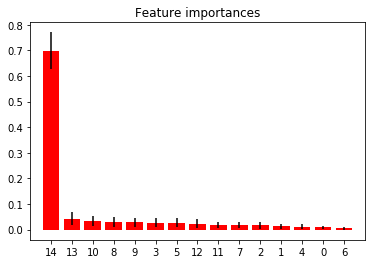

In [22]:
# Plot the feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Submission

Let's preprocess the submission data and use the model to make predictions to submit

In [12]:
submission = pd.read_csv(r'C:\Users\alexi\testing_input_A9o5RSM.csv',dtype=np.float64)

In [13]:
X_sub = preprocess(submission)
y_sub = forest.predict(X_sub)
pd.DataFrame(y_sub).to_csv('submission_ENS_10.csv')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    4.9s finished


## Conclusion

Our baseline reaches $error = 0.45$ with <b>linear regression</b>

Random forests regressor gives : $error = 0.40$, with a learning time : 5 minutes

Note that, here we considered the problem only as a <b>spatial regression problem.</b> Considering features at time t and close stations <br>
If we want to improve our results, we should also consider taking into account the <b>temporal contribution.</b>

Let's try <b>Recurrent Neural Network</b> models in another notebook.